# Temporal spectra and decorrelations


In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt

import numpy as np
import xarray as xr

import crocosi.postp as pp

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py:137: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(28*2)
#
client = Client(cluster)
client

Client Scheduler: tcp://10.148.1.99:49482 Dashboard: http://10.148.1.99:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## Load data

In [78]:
#root_path = '/home1/scratch/aponte/'
root_path = '/home/c11-data/Test_aponte/jetn/'
run = 'jet_cfg1_wp75_4km_1500a2000j_itide/'

#r = pp.Run(root_path+run, prefix='file_', open_nc=['surf'], verbose=True)
r = pp.Run(root_path+run, open_nc=['surf'], tdir_max=2, verbose=True)
r['surf'] = r['surf'].rename({'time_instant': 'time'})

Analysing directory /home1/scratch/aponte/jet_cfg1_wp75_4km_1500a2000j_itide/
Found 2 segments
Found 2 grid files
Found 4 surf files
Detected time step of 300.0 s
Detected theta_s = 5.0
Detected theta_b = 0.0
Detected Hc = 100.0 m
Detected rho0 = 1000.0 kg/m^3
Detected H = 4000.0 m
Found 9 columns in output.mpi:
['STEP', 'time[DAYS]', 'KINETIC_ENRG', 'POTEN_ENRG', 'TOTAL_ENRG', 'NET_VOLUME', 'trd', 'ENSTROPHY', 'BTKIN_ENRG']
Opening NC datasets:  ['grid', 'surf']
Grid size: (L ,M, N) = (258, 722, 50)


In [70]:
#r['surf']

In [79]:
V = ['u', 'v']
dij = 2
ds = (r['surf'][V].isel({'x_rho': slice(0,None,dij), 'x_u': slice(0,None,dij),
                         'y_rho': slice(0,None,dij), 'y_v': slice(0,None,dij)})
     ).squeeze()
print('dataset size: %.0f GB' %(ds.nbytes/1e9))

dataset size: 11 GB


In [80]:
ds

<xarray.Dataset>
Dimensions:       (time: 28800, x_rho: 129, x_u: 129, y_rho: 361, y_v: 361)
Coordinates:
  * y_rho         (y_rho) float32 -2000.0 6000.0 14000.0 ... 2870000.0 2878000.0
    time_counter  (time) float64 1.5e+03 1.5e+03 1.5e+03 ... 1.7e+03 1.7e+03
    fu            (y_rho) float32 dask.array<chunksize=(361,), meta=np.ndarray>
    y_u           (y_rho) float32 dask.array<chunksize=(361,), meta=np.ndarray>
  * x_u           (x_u) float32 0.0 8000.0 16000.0 ... 1016000.0 1024000.0
  * time          (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    frho          (y_rho) float32 0.0001029676 0.0001030972 ... 0.0001496236
  * x_rho         (x_rho) float32 -2000.0 6000.0 14000.0 ... 1014000.0 1022000.0
    x_v           (x_rho) float32 dask.array<chunksize=(129,), meta=np.ndarray>
    fv            (y_v) float32 dask.array<chunksize=(361,), meta=np.ndarray>
    s_rho_slice0  float32 -0.01
  * y_v           (y_v) float32 0.0 8000.0 16000.0 ... 2872000.0 2880000.0
Data variables:
    u             (time, y_rho, x_u) float32 dask.array<chunksize=(1, 361, 129), meta=np.ndarray>
    v             (time, y_v, x_rho) float32 dask.array<chunksize=(1, 361, 129), meta=np.ndarray>
Attributes:
    name:         surf
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2020-Feb-03 10:28:55 GMT
    uuid:         979d973b-3250-4199-96c2-7dff8e4f5076

In [81]:
x, y, t = 10, 10, 6*24*20
ds = ds.chunk({'time': t, 'x_rho': x, 'x_u': x, 'y_rho': y, 'y_v': y})

In [82]:
ds = ds.persist()

---

## Spectra: manual computation

In [84]:
from scipy import signal

def _get_E(x, fs=None, ufunc=True, **kwargs):
    ax = -1 if ufunc else 0
    #
    dkwargs = {'window': 'hann', 'return_onesided': False, 
               'detrend': 'linear', 'scaling': 'density'}
    dkwargs.update(kwargs)
    f, E = signal.welch(x, fs=fs, axis=ax, **dkwargs)
    #
    if ufunc:
        return E
    else:
        return f, E

def get_E(v, dt, f=None, **kwargs):
    v = v.chunk({'time': -1})
    _kwargs = {'fs': 1./dt}
    _kwargs.update(kwargs)
    if f is None:
        f, E = _get_E(v.values, ufunc=False, **_kwargs)
        return f, E
    else:
        E = xr.apply_ufunc(_get_E, v,
                    dask='parallelized', output_dtypes=[np.float64],
                    input_core_dims=[['time']],
                    output_core_dims=[['freq_time']],
                    output_sizes={'freq_time': _kwargs['nperseg']}, kwargs=_kwargs)
        return E.assign_coords(freq_time=f).sortby('freq_time')

In [85]:
dt = float((ds.time[1]-ds.time[0]).values)
N = int(20/dt)
f, _ = get_E(ds.u.isel(x_u=0,y_rho=0), dt, nperseg=N)
E = get_E(ds.u, dt, f=f, nperseg=N).persist()

In [86]:
E

<xarray.DataArray 'u' (y_rho: 361, x_u: 129, freq_time: 2879)>
dask.array<getitem, shape=(361, 129, 2879), dtype=float64, chunksize=(10, 10, 2879), chunktype=numpy.ndarray>
Coordinates:
  * y_rho         (y_rho) float32 -2000.0 6000.0 14000.0 ... 2870000.0 2878000.0
    fu            (y_rho) float32 dask.array<chunksize=(10,), meta=np.ndarray>
    y_u           (y_rho) float32 dask.array<chunksize=(10,), meta=np.ndarray>
  * x_u           (x_u) float32 0.0 8000.0 16000.0 ... 1016000.0 1024000.0
    frho          (y_rho) float32 dask.array<chunksize=(10,), meta=np.ndarray>
    s_rho_slice0  float32 -0.01
  * freq_time     (freq_time) float64 -71.97 -71.92 -71.87 ... 71.87 71.92 71.97

In [87]:
E_mean = E.mean('x_u').persist()

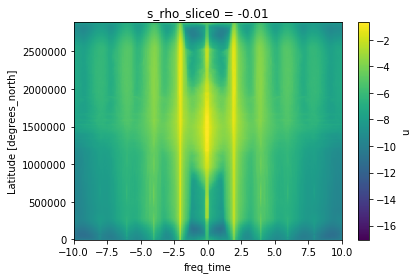

In [90]:
np.log10(E_mean).plot(x='freq_time', xlim=(-10,10))

---

## Spectra: xrft

---

## Decorrelation: manual apply_ufunc

In [ ]:
cluster.close()

In [98]:
def correlate(v1, v2, dt=None, detrend=False, ufunc=True):
    ''' Compute a lagged correlation between two time series
    These time series are assumed to be regularly sampled in time 
    and along the same time line.
    
    Parameters
    ----------
    
        v1, v2: ndarray, pd.Series
            Time series to correlate, the index must be time if dt is not provided
            
        dt: float, optional
            Time step
            
        detrend: boolean, optional
            Turns detrending on or off. Default is False.

    See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.correlate.html
    '''
    
    if detrend:
        v1 = signal.detrend(v1)
        v2 = signal.detrend(v2)        
    
    vv = np.vectorize(np.correlate)(v1, v2, mode='same')
    #return pd.Series(vv[int(vv.size/2):][:N], index=np.arange(N)*dt)


v1 = ds.u.isel(x_u=slice(0,10), y_rho=slice(0,10)).values.transpose((1,2,0))


np.vectorize(np.correlate)(np.moveaxis(v1, 0, -1), np.moveaxis(v1, 0, -1), mode='same')

ValueError: object of too small depth for desired array

In [97]:
v1.shape

(10, 10, 28800)

In [ ]:
def _get_decor(x, fs=None, ufunc=True, **kwargs):
    ax = -1 if ufunc else 0
    #
    dkwargs = {'window': 'hann', 'return_onesided': False, 
               'detrend': 'linear', 'scaling': 'density'}
    dkwargs.update(kwargs)
    f, E = signal.welch(x, fs=fs, axis=ax, **dkwargs)
    #
    if ufunc:
        return E
    else:
        return f, E

def get_E(v, dt, f=None, **kwargs):
    v = v.chunk({'time': -1})
    _kwargs = {'fs': 1./dt}
    _kwargs.update(kwargs)
    if f is None:
        f, E = _get_E(v.values, ufunc=False, **_kwargs)
        return f, E
    else:
        E = xr.apply_ufunc(_get_E, v,
                    dask='parallelized', output_dtypes=[np.float64],
                    input_core_dims=[['time']],
                    output_core_dims=[['freq_time']],
                    output_sizes={'freq_time': _kwargs['nperseg']}, kwargs=_kwargs)
        return E.assign_coords(freq_time=f).sortby('freq_time')

---

In [9]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1283, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1012, in _reconnect
    await self._close()
  File "/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/cli